# Run all Code Boxes From Here until marked

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math as m
import tifffile
from scipy.spatial import KDTree

import os
import pandas as pd
from sklearn.cluster import DBSCAN
from tkinter import filedialog
from tkinter import Tk

from sklearn.cluster import DBSCAN
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

Goals for accuracy

-Greater than 80% positive

-Manual verification

-IMARIS is SOTA

-106.7/5 = 21.34 is nm/pixel

In [2]:
# Open the TIFF movie
with tifffile.TiffFile('Examples/B1_Composite.tif') as tif:
    # Get the number of frames in the movie
    n_frames = len(tif.pages)

    # Read all frames of the movie and store them as a numpy array
    movie = np.zeros((n_frames, tif.pages[0].shape[0], tif.pages[0].shape[1]), dtype='uint16')
    for i in range(n_frames):
        movie[i,:,:] = tif.pages[i].asarray()

    # Print relevant information about the movie
    print('Number of frames: {}'.format(n_frames))
    print('Shape of each frame: {}'.format(tif.pages[0].shape))
    print('Data type of each pixel: {}'.format(tif.pages[0].dtype))

# Display the first frame of the movie
# plt.figure()
# plt.imshow(movie[0,:,:])
# plt.show()

life_act = movie[0]

Number of frames: 4
Shape of each frame: (2560, 2560)
Data type of each pixel: float32


In [3]:
def locate_homer_centers(path, plot=False):
    # Step 1: Load post-synaptic marker (e.g., Homer, PSD95) ThunderSTORM data
    outputindex = os.path.basename(os.path.dirname(path))
    dim = 2
    picasso = 0  # if Picasso = 1, otherwise = 0
    synapse_size = 50  # cluster size in nm
    min_neighbours = 5  # minimum number of neighbours w/n synapse_size radius for cluster filtering

    root = Tk()
    root.withdraw()
    # file_path = filedialog.askopenfilename(initialdir=path, title="Select the Homer (or synaptic marker) file to process",
    #                                        filetypes=(("CSV files", "*.csv"), ("All files", "*.*")))
    file_path = r"C:\Users\icedn\Jupyter\SelvinLab\Selvin-Lab-qPAINT-Segmentation\Examples\B1_aHomer_corrected.csv"

    try:
        ThunderSTORM1 = pd.read_csv(file_path, sep=',', skiprows=1, header=None)
    except Exception:
        ThunderSTORM1 = pd.read_excel(file_path, header=None)

    if picasso == 1:
        ThunderSTORM1.iloc[:, 1] = ThunderSTORM1.iloc[:, 1] + 1

    ThunderSTORM = [ThunderSTORM1.values]
    if dim == 3:
        palmX = ThunderSTORM[0][:, 2]
        palmY = ThunderSTORM[0][:, 3]
        palmZ = ThunderSTORM[0][:, 4]
        data_Syn = np.column_stack((palmX, palmY, palmZ))
    elif dim == 2:
        palmX = ThunderSTORM[0][:, 2]
        palmY = ThunderSTORM[0][:, 3]
        data_Syn = np.column_stack((palmX, palmY))

    # Finding clusters
    db = DBSCAN(eps=synapse_size, min_samples=min_neighbours, metric='euclidean').fit(data_Syn)
    Class = db.labels_
    type_ = np.array([1 if label != -1 else 0 for label in Class])

    # Make new matrix
    cluster_avgs = []
    if dim == 3:
        Syn = np.column_stack((palmX, palmY, 0.79 * palmZ, Class, type_))
        # Separate and plot clusters
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        for k in np.unique(Class):
            if k != -1:
                cluster_points = Syn[Syn[:, 3] == k]
                ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], s=20)
    elif dim == 2:
        Syn = np.column_stack((palmX, palmY, Class, type_))
        # Separate and plot clusters
        if plot: plt.figure()

        for k in np.unique(Class):
            if k != -1:
                cluster_points = Syn[Syn[:, 2] == k]
                cluster_avgs.append((sum(cluster_points[:, 0])/len(cluster_points[:, 0]), sum(cluster_points[:, 1])/len(cluster_points[:, 1])))
                if plot: plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=20)
    if plot:
        plt.axis('equal')
        # plt.xlim(500, 570)
        # plt.ylim(39530, 39600)
        plt.show()
    return cluster_avgs

In [4]:
path = r'C:\Users\icedn\Jupyter\SelvinLab\Selvin-Lab-qPAINT-Segmentation\Examples'
nm_per_pixel = 21.34
homer_centers_nm = np.array(locate_homer_centers(path))
homer_centers_px = homer_centers_nm/nm_per_pixel
homer_centers_int = homer_centers_px.astype(int)

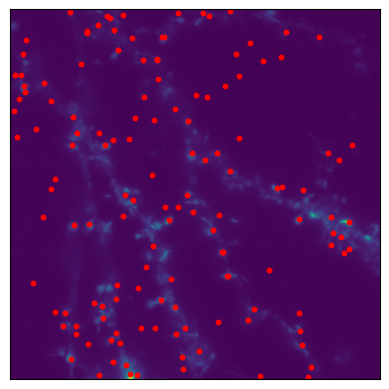

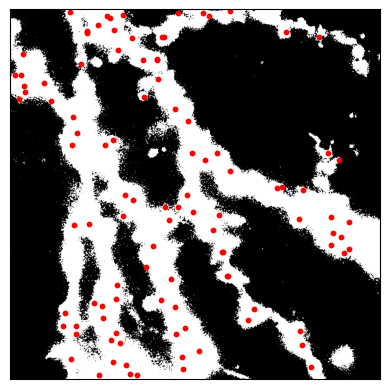

In [5]:
life_act_threshold = 400
plot = True
threshold_map = np.array(life_act > life_act_threshold)
relevant_homer_centers = np.array([homer_centers_px[i] for i in range(len(homer_centers_px)) if threshold_map[homer_centers_int[i][1], homer_centers_int[i][0]]])

if plot:
    plt.figure()
    plt.imshow(life_act, origin='lower')
    plt.scatter(homer_centers_px[:, 0], homer_centers_px[:, 1], s=10, color='r')
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.show()

    plt.figure()
    plt.imshow(threshold_map, origin='lower', cmap='gray')
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.scatter(relevant_homer_centers[:, 0], relevant_homer_centers[:, 1], s=10, color='r')
    plt.show()

In [6]:
# read the csv file into a pandas dataframe
GluA1_df = pd.read_csv(r'Examples\B1_GluA1_corrected.csv', delimiter=',')
GluA2_df = pd.read_csv(r'Examples\B1_GluA2_corrected.csv', delimiter=',')

# extract the x and y columns
raw_GluA1_x = GluA1_df['x [nm]']/nm_per_pixel
raw_GluA1_y = GluA1_df['y [nm]']/nm_per_pixel
GluA1_frames = GluA1_df['frame']

# Reshape into points
raw_GluA1_pts = np.array(list(zip(raw_GluA1_x, raw_GluA1_y)))

In [7]:
#  xs: x locations (usually give raw_GluA1_x)
#  ys: y locations (usually give raw_GluA1_y)
#  N: Number of samples within radius R of a point for it to pass threshold for clusters
#  R: Radius for above
#  eps: Maximum distance for two points to be in the same cluster
#  min_samples: minimum samples in 1 cluster
def filter_and_cluster_points(xs, ys, N, R, eps, min_samples):
    xs = np.array(xs)
    ys = np.array(ys)
    points = np.array(list(zip(xs, ys)))
    kdtree = KDTree(points)

    # Find points with at least N other points within radius R
    neighbors = kdtree.query_ball_point(points, R)
    neighbor_counts = np.array([len(neighbors_i) - 1 for neighbors_i in neighbors])  # Subtract 1 to exclude the point itself
    filtered_indices = np.where(neighbor_counts >= N)
    np_filtered_indices = np.array(filtered_indices[0])

    # Filtered points
    filtered_points = points[filtered_indices]

    # Cluster the filtered points using DBSCAN
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(filtered_points)
    labels = clustering.labels_

    # Calculate cluster centers (mean of points in each cluster)
    cluster_centers = np.array([filtered_points[labels == i].mean(axis=0) for i in range(np.max(labels) + 1)])

    # Get indices for each cluster
    cluster_points = [filtered_points[labels == i] for i in range(np.max(labels) + 1)]
    cluster_indices = [np_filtered_indices[labels == i] for i in range(np.max(labels) + 1)]
    return filtered_points, cluster_centers, cluster_points, cluster_indices

def plot_map(homer=True, centers=True, raw=True, clusters=True, background=True, legend=True, old_circles=False, scale_bar=True, labels=False):
    scaled_x_lim = ((x_lim[0]+x_delta) - ((x_lim[1]-x_lim[0])*(scale-1)/2), (x_lim[1]+x_delta) + ((x_lim[1]-x_lim[0])*(scale-1)/2))
    scaled_y_lim = ((y_lim[0]+y_delta) - ((y_lim[1]-y_lim[0])*(scale-1)/2), (y_lim[1]+y_delta) + ((y_lim[1]-y_lim[0])*(scale-1)/2))
    plt.figure(dpi=150)
    if raw:
        plt.scatter(raw_GluA1_x, raw_GluA1_y, s=(0.1/np.sqrt(scale)), color='yellow', label="GluA1")
    if clusters:
        plt.scatter(filtered_cluster_points[:, 0], filtered_cluster_points[:, 1], s=(0.1/np.sqrt(scale)), color='red', label="Clustered Points")
    if centers:
        plt.scatter(filtered_cluster_centers[:, 0], filtered_cluster_centers[:, 1], marker='x', linewidths=(1/np.sqrt(scale)), s=(30/np.sqrt(scale)), color='aqua', label='Cluster Centers')
    if homer:
        plt.scatter(relevant_homer_centers[:, 0], relevant_homer_centers[:, 1], s=(60/np.sqrt(scale)), marker='v', color='chartreuse', edgecolor='black', label="Homer Centers")
    if old_circles:
        for point in relevant_homer_centers:
            small_circle = plt.Circle(point, 500/nm_per_pixel, fill = False, color='red')
            big_circle = plt.Circle(point, 1500/nm_per_pixel, fill = False, color='red')
            plt.gca().add_artist(small_circle)
            plt.gca().add_artist(big_circle)
    if scale_bar:
        fontprops = fm.FontProperties(size=8)
        scalebar = AnchoredSizeBar(plt.gca().transData,
                                1000/nm_per_pixel,  # length of scale bar
                                '1 micron',  # label
                                'lower right',  # position
                                pad=0.1,
                                color='white',
                                frameon=False,
                                size_vertical=0.05,
                                fontproperties=fontprops)

        plt.gca().add_artist(scalebar)
    if labels:
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('XY Coordinates')
    else:
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
    if background:
        plt.imshow(life_act, cmap='magma')

    plt.xlim(scaled_x_lim[0], scaled_x_lim[1])
    plt.ylim(scaled_y_lim[0], scaled_y_lim[1])
    if legend: plt.legend(loc='lower left')
    plt.show()

# Marked

 This box below is the main box that runs the filtering, you can adjust the x_lim, y_lim variables to change where in the frame we are looking. The filter_and_cluster_points(xs, ys, N, R, eps, min_samples) function variables are defined above

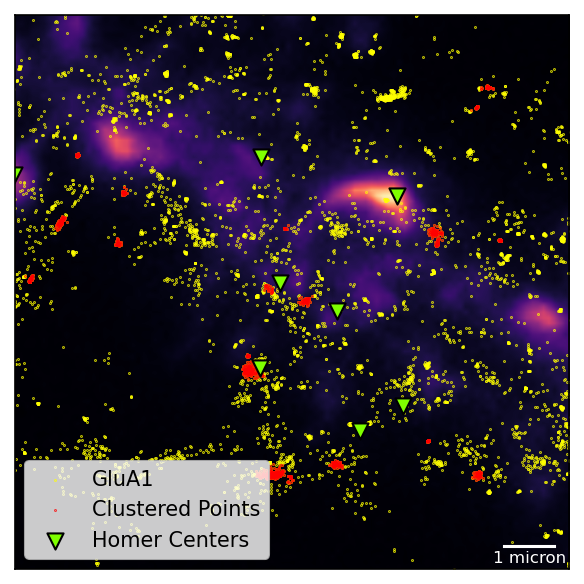

In [8]:
filtered_points, cluster_centers, cluster_points, cluster_indices = filter_and_cluster_points(raw_GluA1_x, 
                                                                                              raw_GluA1_y, 
                                                                                              20, 
                                                                                              120/nm_per_pixel, 
                                                                                              100/nm_per_pixel, 
                                                                                              25)
# Clusters Dictionary
clusters = []
filter_clusters_by_lifeact = True
filtered_cluster_centers = []
filtered_cluster_points = []
for i in range(len(cluster_centers)):
    cluster = {}
    cluster['center'] = np.array(cluster_centers[i])
    if filter_clusters_by_lifeact and not threshold_map[round(cluster['center'][0]), round(cluster['center'][1])]:
        continue
    pts = []
    for j in range(len(cluster_points[i])):
        pts.append(list(cluster_points[i][j]))
        filtered_cluster_points.append(list(cluster_points[i][j]))
    cluster['points'] = np.array(pts)
    cluster['indices'] = cluster_indices[i]
    cluster['frames'] = np.array(GluA1_frames[cluster_indices[i]])
    clusters.append(cluster)
    filtered_cluster_centers.append(cluster_centers[i])

filtered_cluster_centers = np.array(filtered_cluster_centers)
filtered_cluster_points = np.array(filtered_cluster_points)

x_delta = 0
y_delta = 0
scale = 1
x_lim = (2000, 2500)
y_lim = (750, 1250)
# plot_map(raw=True, legend=True, centers=False, clusters=False, old_circles=True)
plot_map(raw=True, legend=True, centers=False, clusters=True, old_circles=False)

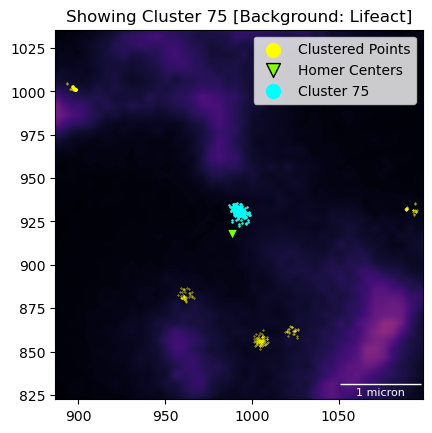

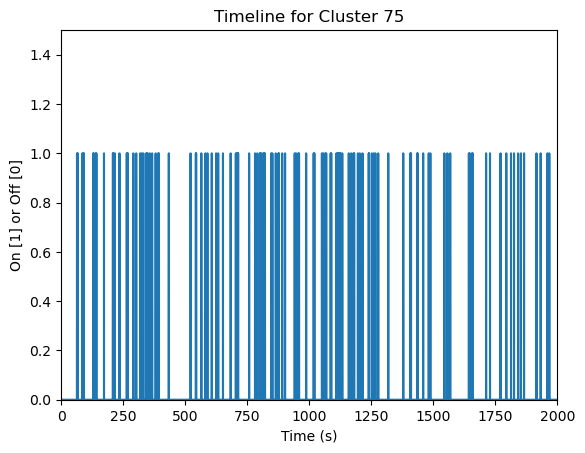

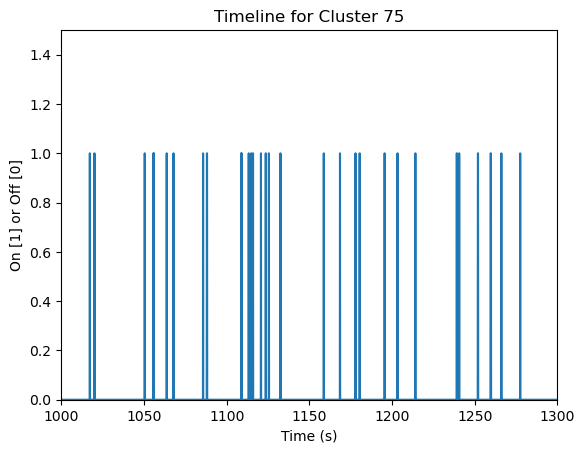

In [22]:
time_per_frame = 0.1 # seconds

def show_cluster(index, buffer=100, clusters=clusters, life_act=life_act, scale_bar=True, print_center=True, show_clusters=True, homer=True):
    cluster = clusters[index]
    center = cluster['center']
    pts = cluster['points']
    plt.figure()
    plt.imshow(life_act, cmap='magma', origin='lower')
    plt.xlim(np.min(pts[:, 0]) - buffer, np.max(pts[:, 0]) + buffer)
    plt.ylim(np.min(pts[:, 1]) - buffer, np.max(pts[:, 1]) + buffer)
    if print_center: 
        plt.scatter(center[0], center[1], marker='x', linewidth=10, s=5, color='red', label="Cluster Center")
    if scale_bar:
        fontprops = fm.FontProperties(size=8)
        scalebar = AnchoredSizeBar(plt.gca().transData,
                                1000/nm_per_pixel,  # length of scale bar
                                '1 micron',  # label
                                'lower right',  # position
                                pad=0.1,
                                color='white',
                                frameon=False,
                                size_vertical=0.05,
                                fontproperties=fontprops)
        plt.gca().add_artist(scalebar)
    if show_clusters:
        plt.scatter(filtered_cluster_points[:, 0], filtered_cluster_points[:, 1], s=(0.1/np.sqrt(scale)), color='yellow', label="Clustered Points")
    if homer:
        plt.scatter(relevant_homer_centers[:, 0], relevant_homer_centers[:, 1], s=(60/np.sqrt(scale)), marker='v', color='chartreuse', edgecolor='black', label="Homer Centers")
    plt.scatter(pts[:, 0], pts[:, 1], s=0.5, color='aqua', label=f'Cluster {index}')
    plt.title(f"Showing Cluster {index} [Background: Lifeact]")
    for handle in plt.legend().legend_handles:
        handle._sizes = [100]
    plt.show()
    return

def cluster_time_plot(index, plot_range=[-1,-1], clusters=clusters, df=GluA1_df):
    frames = clusters[index]['frames']
    all_frames = range(max(df['frame']))
    times = [frame*time_per_frame for frame in all_frames]
    vals = [1 if frame in frames else 0 for frame in all_frames]
    plt.figure()
    plt.plot(times, vals)
    plt.title(f"Timeline for Cluster {index}")
    plt.xlabel("Time (s)")
    plt.ylabel("On [1] or Off [0]")
    plt.ylim(0, 1.5)
    if plot_range != [-1, -1]:
        plt.xlim(plot_range[0], plot_range[1])
    plt.show()

index = 75
show_cluster(index, 100, print_center=False)
cluster_time_plot(index, [0, 2000])
cluster_time_plot(index, [1000, 1300])